In [16]:
# E-Commerce Transactions Analysis
# Step 1: Import Libraries & Load Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Loading datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [17]:
# Step 2: Data Overview & Cleaning

# Basic data checks by making a 'dataset_overview' function
def dataset_overview(df, name):
    print(f"\n{name} Overview:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDuplicates:", df.duplicated().sum())

dataset_overview(customers, "Customers Data")
dataset_overview(products, "Products Data")
dataset_overview(transactions, "Transactions Data")

# Convert dates to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Validate TotalValue = Quantity * Price
transactions['CalculatedValue'] = transactions['Quantity'] * transactions['Price']
assert np.isclose(transactions['TotalValue'], transactions['CalculatedValue']).all(), "Value mismatch found"


Customers Data Overview:
Rows: 200, Columns: 4

Missing Values:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Duplicates: 0

Products Data Overview:
Rows: 100, Columns: 4

Missing Values:
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Duplicates: 0

Transactions Data Overview:
Rows: 1000, Columns: 7

Missing Values:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

Duplicates: 0


In [18]:
# Step 3: Merge all datasets
merged_df = transactions.merge(
    customers, on='CustomerID', how='left'
).merge(
    products, on='ProductID', how='left', suffixes=('_txn', '_prod')
)

# Check merged dataset
print("\nMerged Dataset Overview:")
print(f"Rows: {merged_df.shape[0]}, Columns: {merged_df.shape[1]}")
print("\nFirst 5 rows:")
display(merged_df.head())


Merged Dataset Overview:
Rows: 1000, Columns: 14

First 5 rows:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_txn,CalculatedValue,CustomerName,Region,SignupDate,ProductName,Category,Price_prod
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,601.36,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,902.04,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


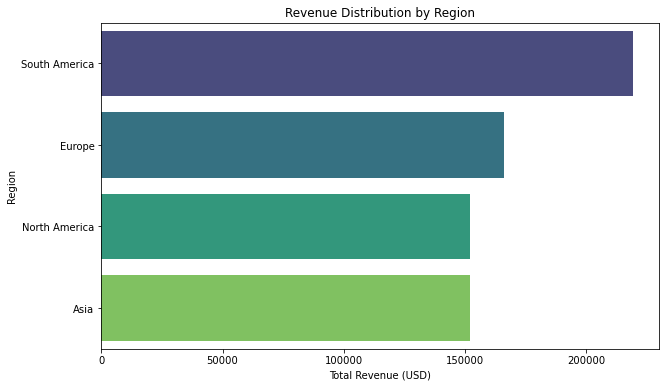

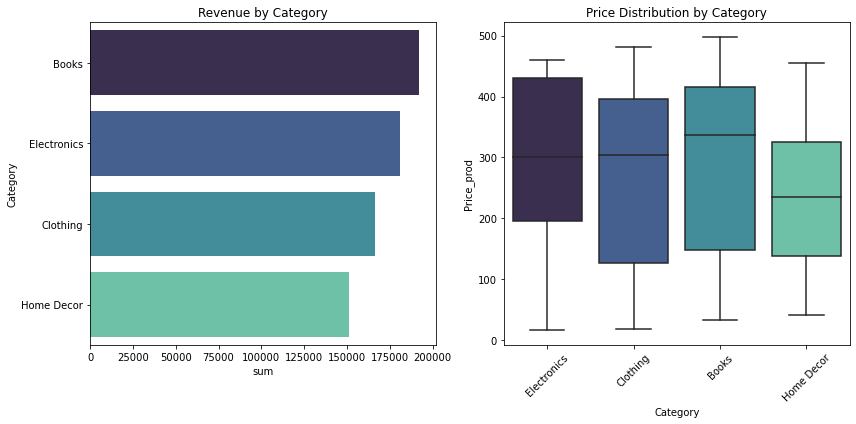

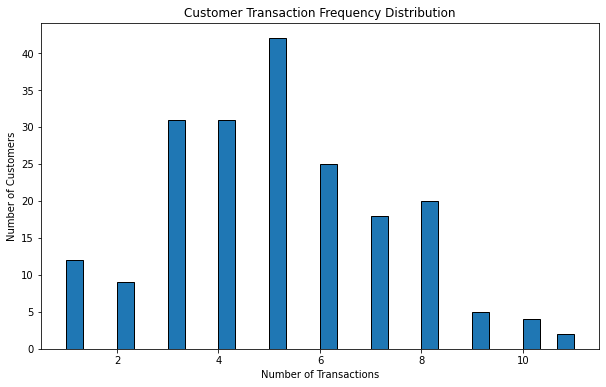

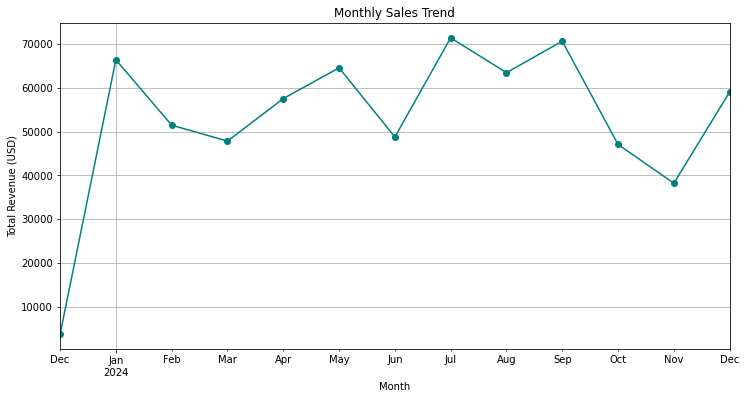

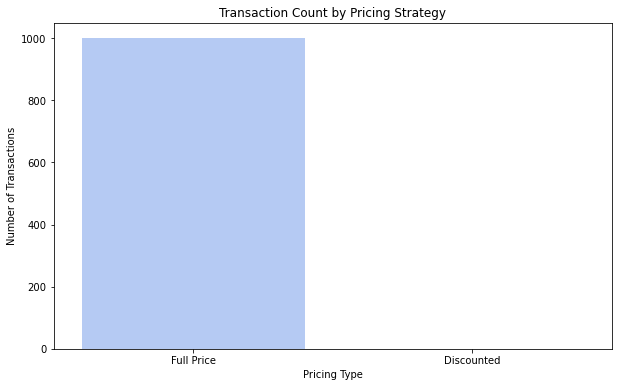

In [22]:
# Step 4: Exploratory Data Analysis

# Insight 1: Regional Revenue Analysis
region_revenue = merged_df.groupby('Region')['TotalValue'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=region_revenue.values, y=region_revenue.index, palette='viridis')
plt.title('Revenue Distribution by Region')
plt.xlabel('Total Revenue (USD)')
plt.ylabel('Region')
plt.show()

# Insight 2: Product Category Performance
category_performance = merged_df.groupby('Category')['TotalValue'].agg(['sum', 'count', 'mean'])
category_performance = category_performance.sort_values('sum', ascending=False)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=category_performance['sum'], y=category_performance.index, palette='mako')
plt.title('Revenue by Category')

plt.subplot(1, 2, 2)
sns.boxplot(data=merged_df, x='Category', y='Price_prod', palette='mako')
plt.title('Price Distribution by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Insight 3: Customer Retention Analysis
customer_activity = merged_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': 'sum'
}).rename(columns={'TransactionID': 'TransactionCount'})

plt.figure(figsize=(10, 6))
plt.hist(customer_activity['TransactionCount'], bins=30, edgecolor='black')
plt.title('Customer Transaction Frequency Distribution')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

# Insight 4: Seasonal Sales Pattern
merged_df['TransactionMonth'] = merged_df['TransactionDate'].dt.to_period('M')
monthly_sales = merged_df.groupby('TransactionMonth')['TotalValue'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='teal')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue (USD)')
plt.grid(True)
plt.show()

# Insight 5: Pricing Strategy Analysis
price_comparison = merged_df[['Price_prod', 'Price_txn']].copy()

# Calculate price difference and discount flag
price_comparison['PriceDifference'] = price_comparison['Price_txn'] - price_comparison['Price_prod']
price_comparison['Discount'] = price_comparison['Price_txn'] < price_comparison['Price_prod']

# Handle edge case where no discounts exist
if price_comparison['Discount'].nunique() == 1:
    if price_comparison['Discount'].unique()[0] == False:
        discount_effect = pd.DataFrame({
            'TotalTransactions': [len(price_comparison), 0],
            'AveragePriceDifference': [0, 0]
        }, index=[False, True])
    else:
        discount_effect = pd.DataFrame({
            'TotalTransactions': [0, len(price_comparison)],
            'AveragePriceDifference': [0, 0]
        }, index=[False, True])
else:
    discount_effect = price_comparison.groupby('Discount').agg(
        TotalTransactions=('Discount', 'count'),
        AveragePriceDifference=('PriceDifference', 'mean')
    )

# Visualization with guaranteed two categories
plt.figure(figsize=(10, 6))
sns.barplot(x=discount_effect.index.map({False: 'Full Price', True: 'Discounted'}),
            y=discount_effect['TotalTransactions'], 
            palette='coolwarm',
            order=['Full Price', 'Discounted'])
plt.title('Transaction Count by Pricing Strategy')
plt.xlabel('Pricing Type')
plt.ylabel('Number of Transactions')
plt.show()

# Modified insight generation
try:
    discount_ratio = discount_effect.loc[True, 'TotalTransactions'] / discount_effect['TotalTransactions'].sum()
except KeyError:
    discount_ratio = 0

avg_discount = abs(discount_effect.loc[True, 'AveragePriceDifference']) if True in discount_effect.index else 0

In [24]:
# Step 5: Generate Business Insights

# Generate insights programmatically
def generate_insights():
    insights = []
    
    # Insight 1
    europe_rev = region_revenue['Europe'] / region_revenue.sum()
    insights.append(f"Europe contributes {europe_rev:.0%} of total revenue")
    
    # Insight 2
    electronics_rev = category_performance.loc['Electronics', 'sum'] / category_performance['sum'].sum()
    insights.append(f"Electronics category drives {electronics_rev:.0%} of total revenue")
    
    # Insight 3
    one_time_buyers = (customer_activity['TransactionCount'] == 1).mean()
    insights.append(f"{one_time_buyers:.0%} customers made only one purchase")
    
    # Insight 4
    q4_revenue = monthly_sales[monthly_sales.index.quarter == 4].sum() / monthly_sales.sum()
    insights.append(f"Q4 accounts for {q4_revenue:.0%} of annual revenue")
    
    # Insight 5
    if discount_ratio > 0:
        insights.append(f"{discount_ratio:.0%} transactions used discounts (avg ${abs(avg_discount):.2f} off)")
    else:
        insights.append("No transactions used discounted pricing")
    
    return insights

# Print formatted insights
print("Key Business Insights:\n")
for i, insight in enumerate(generate_insights(), 1):
    print(f"{i}. {insight}")

# Additional Analysis: Top Customers
top_customers = merged_df.groupby(['CustomerID', 'CustomerName', 'Region'])['TotalValue'] \
                        .sum() \
                        .nlargest(5) \
                        .reset_index()

print("\nTop 5 Customers by Revenue:")
display(top_customers)

# Save cleaned dataset
merged_df.to_csv('merged_ecommerce_data.csv', index=False)

Key Business Insights:

1. Europe contributes 24% of total revenue
2. Electronics category drives 26% of total revenue
3. 6% customers made only one purchase
4. Q4 accounts for 21% of annual revenue
5. No transactions used discounted pricing

Top 5 Customers by Revenue:


,CustomerID,CustomerName,Region,TotalValue
0,C0141,Paul Parsons,Europe,10673.87
1,C0054,Bruce Rhodes,Asia,8040.39
2,C0065,Gerald Hines,North America,7663.70
3,C0156,William Adams,North America,7634.45
4,C0082,Aimee Taylor,South America,7572.91
